### Bistable wilson and cowan like model

from : https://elifesciences.org/articles/22425#fig5

In [203]:
# for fast array manipulation
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for numerical ODE integration
from scipy.integrate import odeint
# for nonlinear equations
from scipy.optimize import fsolve
# to display plots in-line
%matplotlib inline
plt.style.use('ggplot')

In [204]:
def sigmoid(x, a, thr):
    return 1 / (1 + np.exp(-a * (x - thr)))

def threshold_linear(x,thr,gain):
    thresholded = x-thr
    if thresholded > 0:
        return gain*thresholded
    else:
        return 0 
    
vthreshold_linear = np.vectorize(threshold_linear)

In [205]:
# Time constant of neural pop in seconds
tau_e = 0.010
tau_i = 0.002
tau_a = 0.5
# Synapse strength
j_ee = 5
j_ei = 1
j_ie = 10
j_ii = 0.5
# Adaptation parameter
beta = 5
tau_a = 0.5
# threshold and gains
g_e = 1
g_i = 4
thr_i = 25
thr_e = 0 # to play with
# Input currents
I_e = 5.5
# I_e-thr_e = 3 which is equivalent to taking I_e = 0 and thr_e = -3 as in the paper

# Ornstein Uhlenbeck process variables
tau_O_U = .001
sigma_O_U = 1

In [206]:
# this function returns the right hand side of the Wilson-Cowan equation
# (both, in a 2-vector)
def rate_model(y, t, x_O_U, x_O_U_inh,time_end,n_steps):
    E = y[0]
    I = y[1]
    A = y[2]
    y1 = (-E + vthreshold_linear(j_ee*E-j_ei*I-A+I_e+x_O_U[int((t/time_end)*n_steps)-1],thr_e, g_e))/tau_e
    y2 = (-I + vthreshold_linear(j_ie*E-j_ii*I+x_O_U_inh[int((t/time_end)*n_steps)-1],thr_i,g_i))/tau_i
    y3 = (-A + beta*E)/tau_a
    return [y1, y2,y3]

# # Ornstein-Uhlenbeck langevin equation
# def Ornstein_Uhlenbeck(y, t):
#     return -y/tau_O_U


In [207]:
# simulation duration and step size
n_steps = 10000
time_end = 10
dt = time_end/n_steps
time = np.linspace(0, time_end, n_steps)
# Ornstein Uhlenbeck
sigma_bis = sigma_O_U * np.sqrt(2. / tau_O_U)
sqrtdt = np.sqrt(dt)
x_O_U = np.zeros(n_steps)

for i in range(n_steps - 1):
    x_O_U[i + 1] = x_O_U[i] + dt * (-(x_O_U[i]) / tau_O_U) + \
        sigma_bis * sqrtdt * np.random.randn()

x_O_U_inh = np.zeros(n_steps)
for i in range(n_steps - 1):
    x_O_U_inh[i + 1] = x_O_U_inh[i] + dt * (-(x_O_U_inh[i]) / tau_O_U) + \
        sigma_bis * sqrtdt * np.random.randn()

# starting point, hopefully inside the basin of attraction of our attractor
E0, I0, A0 = 0, 0, 0 # try changing this

# find the solution with scint.odeint
odesol = odeint(rate_model, [E0, I0, A0], time, args= (x_O_U,x_O_U_inh,time_end,n_steps)) 
# separate the two solutions
exc_timeseries, inh_timeseries, a_timeseries = odesol.T


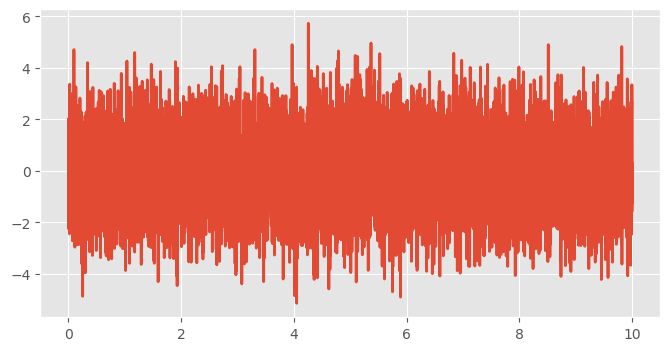

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(time, x_O_U, lw=2)

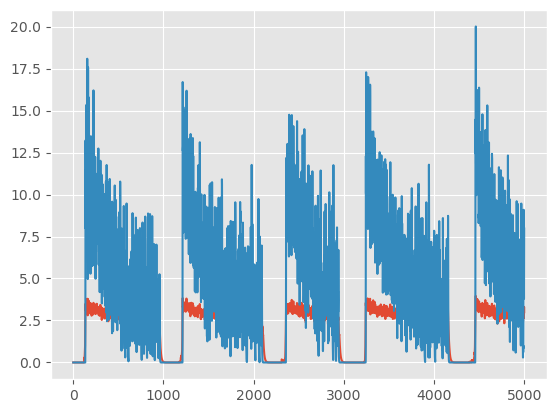

In [209]:
plt.plot(exc_timeseries[-5000:]);
plt.plot(inh_timeseries[-5000:]);

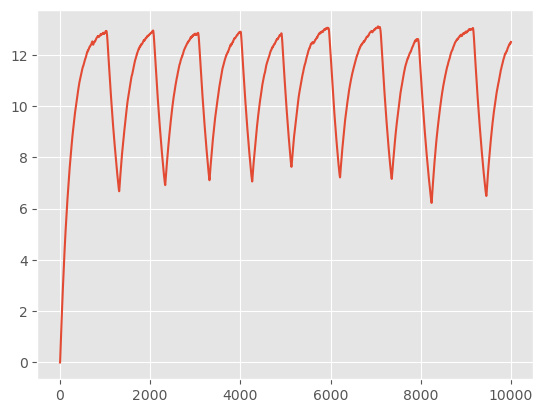

In [210]:
plt.plot(a_timeseries)